In [7]:
!pip install youtube-dl moviepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 9.9 MB/s eta 0:00:00


In [8]:
!pip install pafy

# Imports

In [9]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [10]:
seed_const=27
np.random.seed(seed_const)
random.seed(seed_const)
tf.random.set_seed(seed_const)

# Download and Visualize data

In [11]:
#download UCF50 dataset
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

#unzip the data
!unrar x UCF50.rar -y

Streaming output truncated to the last 5000 lines.
Extracting  UCF50/HorseRace/v_HorseRace_g16_c03.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g16_c04.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g16_c05.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c01.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c02.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c03.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c04.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c05.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g18_c01.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g18_c02.avi                       23%  OK 
Extracting  UCF50/HorseRace/v

In [12]:
all_classes_names=os.listdir('UCF50')
i=-1
for elem in all_classes_names:
  i+=1
  print(str(i)+" "+elem)

0 Basketball
1 Diving
2 JavelinThrow
3 SalsaSpin
4 PlayingGuitar
5 HighJump
6 TaiChi
7 Punch
8 SkateBoarding
9 MilitaryParade
10 ThrowDiscus
11 Biking
12 Kayaking
13 RopeClimbing
14 RockClimbingIndoor
15 Fencing
16 JumpingJack
17 WalkingWithDog
18 PlayingViolin
19 Swing
20 PommelHorse
21 Lunges
22 PizzaTossing
23 PullUps
24 YoYo
25 GolfSwing
26 PlayingTabla
27 Skiing
28 PlayingPiano
29 HorseRace
30 TrampolineJumping
31 VolleyballSpiking
32 Nunchucks
33 Skijet
34 Rowing
35 TennisSwing
36 HulaHoop
37 Drumming
38 JugglingBalls
39 PushUps
40 BreastStroke
41 SoccerJuggling
42 BaseballPitch
43 Mixing
44 Billiards
45 BenchPress
46 JumpRope
47 CleanAndJerk
48 HorseRiding
49 PoleVault


In [13]:
i=[15,20,12,41,40] #label selection

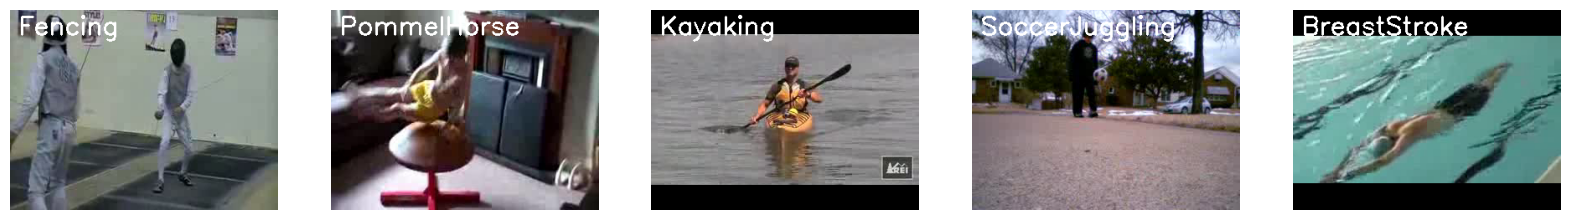

In [14]:
plt.figure(figsize=(20,20))
for counter,ind in enumerate(i,1):
  selected_class_name=all_classes_names[ind]
  video_files_list=os.listdir(f'UCF50/{selected_class_name}')
  selected_vfile_name=random.choice(video_files_list)  #randomly choose a vdo from the folder
  video_reader=cv2.VideoCapture(f'UCF50/{selected_class_name}/{selected_vfile_name}')
  _,bgr_frame=video_reader.read() #reads the first frame of the video
  video_reader.release() #release the VideoCapture() object
  rgb_frame=cv2.cvtColor(bgr_frame,cv2.COLOR_BGR2RGB)  #convt. bgr to rgb for matplotlib
  cv2.putText(rgb_frame,selected_class_name,(10,30),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2) #putting text in the frame
  plt.subplot(1,5,counter) #1 row 5 cols :>
  plt.imshow(rgb_frame)
  plt.axis("off")

Process Dataset

In [15]:
IMAGE_HEIGHT,IMAGE_WIDTH=64,64 #original 64,64
SEQUENCE_LENGTH=20 #original 20
DATASET_DIR='UCF50'
CLASS_LIST=['Punch',"JumpingJack","HighJump","JumpRope"]

In [16]:
def frames_extract(video_path):
  frames_list=[]
  video_reader=cv2.VideoCapture(video_path)
  video_frames_count=int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  skip_frames_window=max(int(video_frames_count/SEQUENCE_LENGTH),1)
  for frame_counter in range(SEQUENCE_LENGTH):
    video_reader.set(cv2.CAP_PROP_POS_FRAMES,frame_counter*skip_frames_window)
    success,frame=video_reader.read()
    if not success:
      break

    resized_frame=cv2.resize(frame,(IMAGE_HEIGHT,IMAGE_WIDTH))
    normalized_frame=resized_frame/255 #brings values between 0 and 1
    frames_list.append(normalized_frame)
  video_reader.release()
  return frames_list

In [17]:
def create_dataset():
  features=[]
  labels=[]
  video_file_paths=[]

  for class_index,class_name in enumerate(CLASS_LIST):
    print(f'Extracting Data of Class: {class_name}')
    files_list=os.listdir(os.path.join(DATASET_DIR,class_name))

    for file_name in files_list:
        video_file_path=os.path.join(DATASET_DIR,class_name,file_name)
        frames=frames_extract(video_file_path)
        if len(frames)==SEQUENCE_LENGTH:
          features.append(frames)
          labels.append(class_index)
          video_file_paths.append(video_file_path)
  features=np.asarray(features)
  labels=np.array(labels)

  return features,labels,video_file_paths

In [18]:
features,labels,video_file_paths=create_dataset()

Extracting Data of Class: Punch
Extracting Data of Class: JumpingJack
Extracting Data of Class: HighJump
Extracting Data of Class: JumpRope


In [19]:
one_hot_encoded_labels=to_categorical(labels)

# Split the Data

In [20]:
features_train,features_test,labels_train,labels_test=train_test_split(features,one_hot_encoded_labels,test_size=0.25,shuffle=True,random_state=seed_const)

In [21]:
features_test[0]

array([[[[0.30980392, 0.30196078, 0.32156863],
         [0.30980392, 0.30196078, 0.32156863],
         [0.29019608, 0.28235294, 0.30196078],
         ...,
         [0.1372549 , 0.07843137, 0.14117647],
         [0.1372549 , 0.07843137, 0.14117647],
         [0.17647059, 0.11764706, 0.18039216]],

        [[0.30980392, 0.30196078, 0.32156863],
         [0.30980392, 0.30196078, 0.32156863],
         [0.29019608, 0.28235294, 0.30196078],
         ...,
         [0.10980392, 0.05098039, 0.11372549],
         [0.1372549 , 0.07843137, 0.14117647],
         [0.17647059, 0.11764706, 0.18039216]],

        [[0.30980392, 0.30196078, 0.32156863],
         [0.30980392, 0.30196078, 0.32156863],
         [0.29019608, 0.28235294, 0.30196078],
         ...,
         [0.14901961, 0.09019608, 0.15294118],
         [0.1372549 , 0.07843137, 0.14117647],
         [0.17647059, 0.11764706, 0.18039216]],

        ...,

        [[0.32941176, 0.33333333, 0.35294118],
         [0.32941176, 0.33333333, 0.35294118]

In [22]:
labels_train[0]

array([1., 0., 0., 0.], dtype=float32)

# Implementation of ConvLSTM Approach

Model Construction

In [ ]:
def create_conv_lstm():
  model=Sequential()
  model.add(ConvLSTM2D(filters=4,kernel_size=(3,3),activation='tanh',data_format="channels_last",recurrent_dropout=0.2,return_sequences=True,
                        input_shape=(SEQUENCE_LENGTH,IMAGE_HEIGHT,IMAGE_WIDTH,3)))
  model.add(MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))


  model.add(ConvLSTM2D(filters=8,kernel_size=(3,3),activation='tanh',data_format="channels_last",recurrent_dropout=0.2,return_sequences=True,))
  model.add(MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters=14,kernel_size=(3,3),activation='tanh',data_format="channels_last",recurrent_dropout=0.2,return_sequences=True,))
  model.add(MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters=16,kernel_size=(3,3),activation='tanh',data_format="channels_last",recurrent_dropout=0.2,return_sequences=True,))
  model.add(MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last'))

  model.add(Flatten())

  model.add(Dense(len(CLASS_LIST),activation="softmax"))

  model.summary()
  return model

In [ ]:
conv_lstm__model=create_conv_lstm()
print("Model was created successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 30, 78, 78, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 30, 39, 39, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 30, 39, 39, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 30, 37, 37, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 30, 19, 19, 8)    0         
 3D)                                                             
                                                        

Check model structure

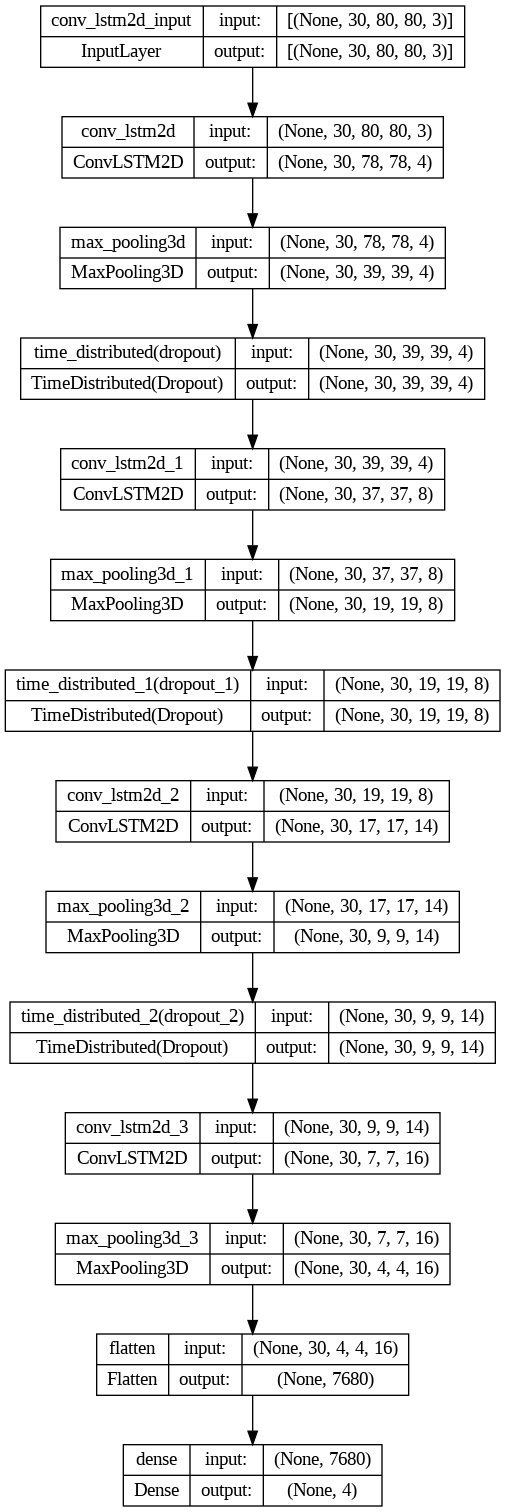

In [ ]:
plot_model(conv_lstm__model,to_file='conv_lst_model_structure.png',show_shapes=True, show_layer_names=True)

Train Model

In [ ]:
early_stopping_callback=EarlyStopping(monitor='val_loss',patience=5,mode='min',restore_best_weights=True)

conv_lstm__model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

conv_lstm_model_training_his=conv_lstm__model.fit(x=features_train,y=labels_train,epochs=10,batch_size=4,shuffle=True,validation_split=0.2,callbacks=[early_stopping_callback])

Epoch 1/10
83/83 [==============================] - 50s 358ms/step - loss: 1.2889 - accuracy: 0.4127 - val_loss: 1.0181 - val_accuracy: 0.5301
Epoch 2/10
83/83 [==============================] - 26s 319ms/step - loss: 0.8417 - accuracy: 0.6295 - val_loss: 0.5838 - val_accuracy: 0.7711
Epoch 3/10
83/83 [==============================] - 27s 322ms/step - loss: 0.4805 - accuracy: 0.8193 - val_loss: 0.3729 - val_accuracy: 0.8795
Epoch 4/10
83/83 [==============================] - 27s 322ms/step - loss: 0.3017 - accuracy: 0.8886 - val_loss: 0.3654 - val_accuracy: 0.8434
Epoch 5/10
83/83 [==============================] - 27s 322ms/step - loss: 0.1958 - accuracy: 0.9247 - val_loss: 0.6757 - val_accuracy: 0.7470
Epoch 6/10
83/83 [==============================] - 27s 321ms/step - loss: 0.1670 - accuracy: 0.9488 - val_loss: 0.7178 - val_accuracy: 0.7952
Epoch 7/10
83/83 [==============================] - 26s 314ms/step - loss: 0.1704 - accuracy: 0.9337 - val_loss: 0.3670 - val_accuracy: 0.8795

Evaluate Model

In [ ]:
model_evaluation_history=conv_lstm__model.evaluate(features_test,labels_test)

5/5 [==============================] - 1s 166ms/step - loss: 0.2799 - accuracy: 0.9065


Save The Model

In [ ]:
model_eval_loss,model_eval_accuracy=model_evaluation_history

date_time_format='%Y_%m_%d__%H_%M_%S'
current_date_time_dt=dt.datetime.now()
cd_str=dt.datetime.strftime(current_date_time_dt,date_time_format)

model_file_name=f'convlstm_model__DateTime_{cd_str}__Loss_{model_eval_loss}__Accuracy_{model_eval_accuracy}.h5'

conv_lstm__model.save(model_file_name)

# Implementation LRCN Model

Construct the Model

In [28]:
def create_LRCN_model():
  model=Sequential()

  model.add(TimeDistributed(Conv2D(16,(3,3),padding='same',activation='relu'),
                             input_shape=(SEQUENCE_LENGTH,IMAGE_HEIGHT,IMAGE_WIDTH,3)))
  model.add(TimeDistributed(MaxPooling2D(4,4)))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(32,(3,3),padding='same',activation='relu')))
  model.add(TimeDistributed(MaxPooling2D(4,4)))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64,(3,3),padding='same',activation='relu')))
  model.add(TimeDistributed(MaxPooling2D(2,2)))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64,(3,3),padding='same',activation='relu')))
  model.add(TimeDistributed(MaxPooling2D(2,2)))

  model.add(TimeDistributed(Flatten()))

  model.add(LSTM(32))
  model.add(Dense(len(CLASS_LIST),activation='softmax'))

  model.summary()
  return model

In [29]:
LRCN_model=create_LRCN_model()

print("Model Created Successfully!")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDis  (None, 30, 80, 80, 16)   448       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 20, 20, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 20, 20, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 20, 20, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 30, 5, 5, 32)    

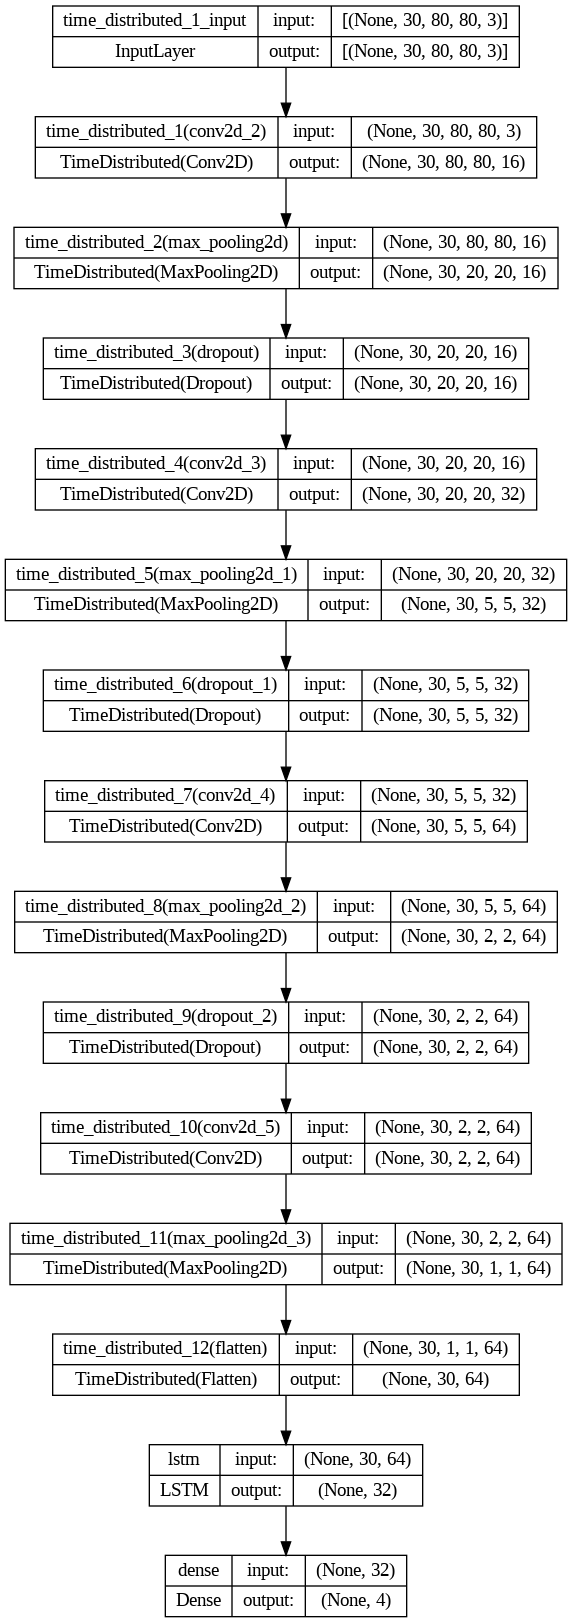

In [30]:
plot_model(LRCN_model,to_file='LRCN_model_structure.png',show_shapes=True, show_layer_names=True)

Compile and Train Model

In [32]:
early_stopping_callback=EarlyStopping(monitor='val_loss',patience=15,mode='min',restore_best_weights=True)

LRCN_model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

LRCN_model_training_history=LRCN_model.fit(x=features_train,y=labels_train,epochs=70,batch_size=4,shuffle=True,validation_split=0.2,callbacks=[early_stopping_callback])

Epoch 1/70
83/83 [==============================] - 18s 31ms/step - loss: 1.3251 - accuracy: 0.3855 - val_loss: 1.0238 - val_accuracy: 0.5301
Epoch 2/70
83/83 [==============================] - 1s 16ms/step - loss: 1.1363 - accuracy: 0.4608 - val_loss: 0.9621 - val_accuracy: 0.5301
Epoch 3/70
83/83 [==============================] - 2s 20ms/step - loss: 1.0488 - accuracy: 0.5151 - val_loss: 0.9162 - val_accuracy: 0.6024
Epoch 4/70
83/83 [==============================] - 2s 23ms/step - loss: 0.9637 - accuracy: 0.5301 - val_loss: 0.8137 - val_accuracy: 0.6024
Epoch 5/70
83/83 [==============================] - 2s 22ms/step - loss: 0.7979 - accuracy: 0.6596 - val_loss: 0.7110 - val_accuracy: 0.7470
Epoch 6/70
83/83 [==============================] - 2s 19ms/step - loss: 0.6923 - accuracy: 0.7018 - val_loss: 0.7183 - val_accuracy: 0.6265
Epoch 7/70
83/83 [==============================] - 1s 16ms/step - loss: 0.5377 - accuracy: 0.7651 - val_loss: 0.4647 - val_accuracy: 0.8434
Epoch 8/70
8

Evaluate

In [34]:
model_evaluation_history=LRCN_model.evaluate(features_test,labels_test)

5/5 [==============================] - 2s 75ms/step - loss: 0.0745 - accuracy: 0.9856


Save the model

In [35]:
model_eval_loss,model_eval_accuracy=model_evaluation_history

date_time_format='%Y_%m_%d__%H_%M_%S'
current_date_time_dt=dt.datetime.now()
cd_str=dt.datetime.strftime(current_date_time_dt,date_time_format)

model_file_name=f'LRCN_model__DateTime_{cd_str}__Loss_{model_eval_loss}__Accuracy_{model_eval_accuracy}.h5'

LRCN_model.save(model_file_name)

# REAL LIFE TEST :p

In [ ]:
def download_yt_vids(youtube_url,download_dir):
  video=pafy.new(youtube_url)
  title=video.title
  video_best=video.getbest()
  outputfile_path=f'{download_dir}/{title}.mp4'
  video_best.download(filepath=outputfile_path,quiet=True)
  return title

Download a test video

In [ ]:
test_vdo_dir='test_videos'
os.makedirs(test_vdo_dir,exist_ok=True)
video_title=download_yt_vids('https://youtu.be/z8z7n1SHkGU?si=WwgZwAd6MJ_VJkbd',test_vdo_dir)
input_video_file_path=f'{test_vdo_dir}/{video_title}.mp4'

ERROR: Unable to extract uploader id; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


OSError: ignored

In [ ]:
test_vdo_dir='test_videos'
os.makedirs(test_vdo_dir,exist_ok=True)
video_title='wew.mp4'
input_video_file_path='/content/lj.mp4'

In [ ]:
def predict_on_video(video_file_path,out_file_path,SEQUENCE_LENGTH):
  video_reader=cv2.VideoCapture(video_file_path)
  original_width=int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
  origial_height=int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
  video_writer=cv2.VideoWriter(out_file_path,cv2.VideoWriter_fourcc('M','P','4','V'),
                                video_reader.get(cv2.CAP_PROP_FPS),(original_width,origial_height))

  frames_queue=deque(maxlen=SEQUENCE_LENGTH)
  predicted_class_name=''

  while video_reader.isOpened():
    ok,frame=video_reader.read()

    if not ok:
      break

    resized_frame=cv2.resize(frame,(IMAGE_HEIGHT,IMAGE_WIDTH))
    normalized_frame=resized_frame/255

    frames_queue.append(normalized_frame)

    if len(frames_queue)==SEQUENCE_LENGTH:
        predicted_label_prob=conv_lstm__model.predict(np.expand_dims(frames_queue,axis=0))[0]

        predicted_label=np.argmax(predicted_label_prob)

        predicted_class_name=CLASS_LIST[predicted_label]


        if max(predicted_label_prob)<=0.98:
          print(str(max(predicted_label_prob))+" Class: "+predicted_class_name+" was deleted!")
          predicted_class_name=''
        else:
          print(str(max(predicted_label_prob))+" Class: "+predicted_class_name+" was kept!")
    cv2.putText(frame,predicted_class_name,(10,30),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)

    video_writer.write(frame)

  video_reader.release()
  video_writer.release()


TESTING

In [ ]:
output_video_file_path=f'{test_vdo_dir}/{video_title}-Output-Seqlen{SEQUENCE_LENGTH}.mp4'

predict_on_video(input_video_file_path,output_video_file_path,SEQUENCE_LENGTH)

1/1 [==============================] - 0s 68ms/step
0.62363094 Class: HighJump was deleted!
1/1 [==============================] - 0s 68ms/step
0.8096309 Class: HighJump was deleted!
1/1 [==============================] - 0s 71ms/step
0.90287775 Class: HighJump was deleted!
1/1 [==============================] - 0s 69ms/step
0.9276427 Class: HighJump was deleted!
1/1 [==============================] - 0s 73ms/step
0.9140767 Class: HighJump was deleted!
1/1 [==============================] - 0s 72ms/step
0.85244423 Class: HighJump was deleted!
1/1 [==============================] - 0s 74ms/step
0.70602673 Class: HighJump was deleted!
1/1 [==============================] - 0s 69ms/step
0.5171693 Class: JumpRope was deleted!
1/1 [==============================] - 0s 79ms/step
0.8124606 Class: JumpRope was deleted!
1/1 [==============================] - 0s 70ms/step
0.93163973 Class: JumpRope was deleted!
1/1 [==============================] - 0s 68ms/step
0.9690401 Class: JumpRope was del

In [ ]:
def plot_metric(model_training_history,metric1,metric2,plt_name):
  metricval1=model_training_history.history[metric1]
  metricval2=model_training_history.history[metric2]

  epochs=len(metricval1)

  plt.plot(epochs,metricval1,'blue',label=metric1)
  plt.plot(epochs,metricval2,'blue',label=metric2)

  plt.title(str(plt_name))
  plt.legend()

In [ ]:
plot_metric(conv_lstm_model_training_his,'accuracy','val_loss','stuff')

NameError: ignored